In [1]:
import sys
from pathlib import Path

project_root = Path("../").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Force reload of lasernet modules to pick up changes
import importlib
if 'lasernet' in sys.modules:
    importlib.reload(sys.modules['lasernet.dataset.loading'])
    importlib.reload(sys.modules['lasernet.dataset'])
    importlib.reload(sys.modules['lasernet'])

# Data Loading Examples

This notebook demonstrates how to use the `PointCloudDataset` class for loading point cloud data.

In [2]:
import torch
from torch.utils.data import DataLoader
from lasernet.dataset import PointCloudDataset, TemperatureSequenceDataset, SliceSequenceDataset

## Loading Temperature Data

In [3]:
dataset = PointCloudDataset(
    field="temperature",
    plane="xy",
    split="train",
    plane_index=-1, # top (highest z coordinate)
)

print(f"Dataset size: {len(dataset)} samples")
print(f"Data directory: {dataset.data_dir}")
print(f"Total files found: {len(dataset.files)}")
print(f"Plane coordinate (z-axis): {dataset.plane_coord:.8f} (top surface)")
print(f"Dataset shape", dataset.shape)

Dataset size: 17 samples
Data directory: /dtu/blackhole/06/168550/Data
Total files found: 24
Plane coordinate (z-axis): 0.00010000 (top surface)
Dataset shape (17, 1, 94, 465)


Get a single frame

In [4]:
frame = dataset[0]

print("Sample structure:")
print(f"  data shape: {frame['data'].shape}")
print(f"  mask shape: {frame['mask'].shape}")
print(f"  timestep: {frame['timestep']}")
print(f"  width coords: {frame['coords']['width'].shape}")
print(f"  height coords: {frame['coords']['height'].shape}")
print(f"  plane coord: {frame['coords']['plane']}")

# statistics
data = frame['data']
mask = frame['mask']
valid_data = data[:, mask]

print(f"\nStatistics:")
print(f"  min: {valid_data.min():.3f}")
print(f"  max: {valid_data.max():.3f}")
print(f"  mean: {valid_data.mean():.3f}")
print(f"  std: {valid_data.std():.3f}")
print(f"  Coverage: {mask.sum()}/{mask.numel()} pixels ({100*mask.float().mean():.1f}%)")

Sample structure:
  data shape: torch.Size([1, 94, 465])
  mask shape: torch.Size([94, 465])
  timestep: 0
  width coords: torch.Size([465])
  height coords: torch.Size([94])
  plane coord: 9.999999747378752e-05

Statistics:
  min: 300.000
  max: 300.000
  mean: 300.000
  std: 0.000
  Coverage: 43710/43710 pixels (100.0%)


## Visualize Temperature Data

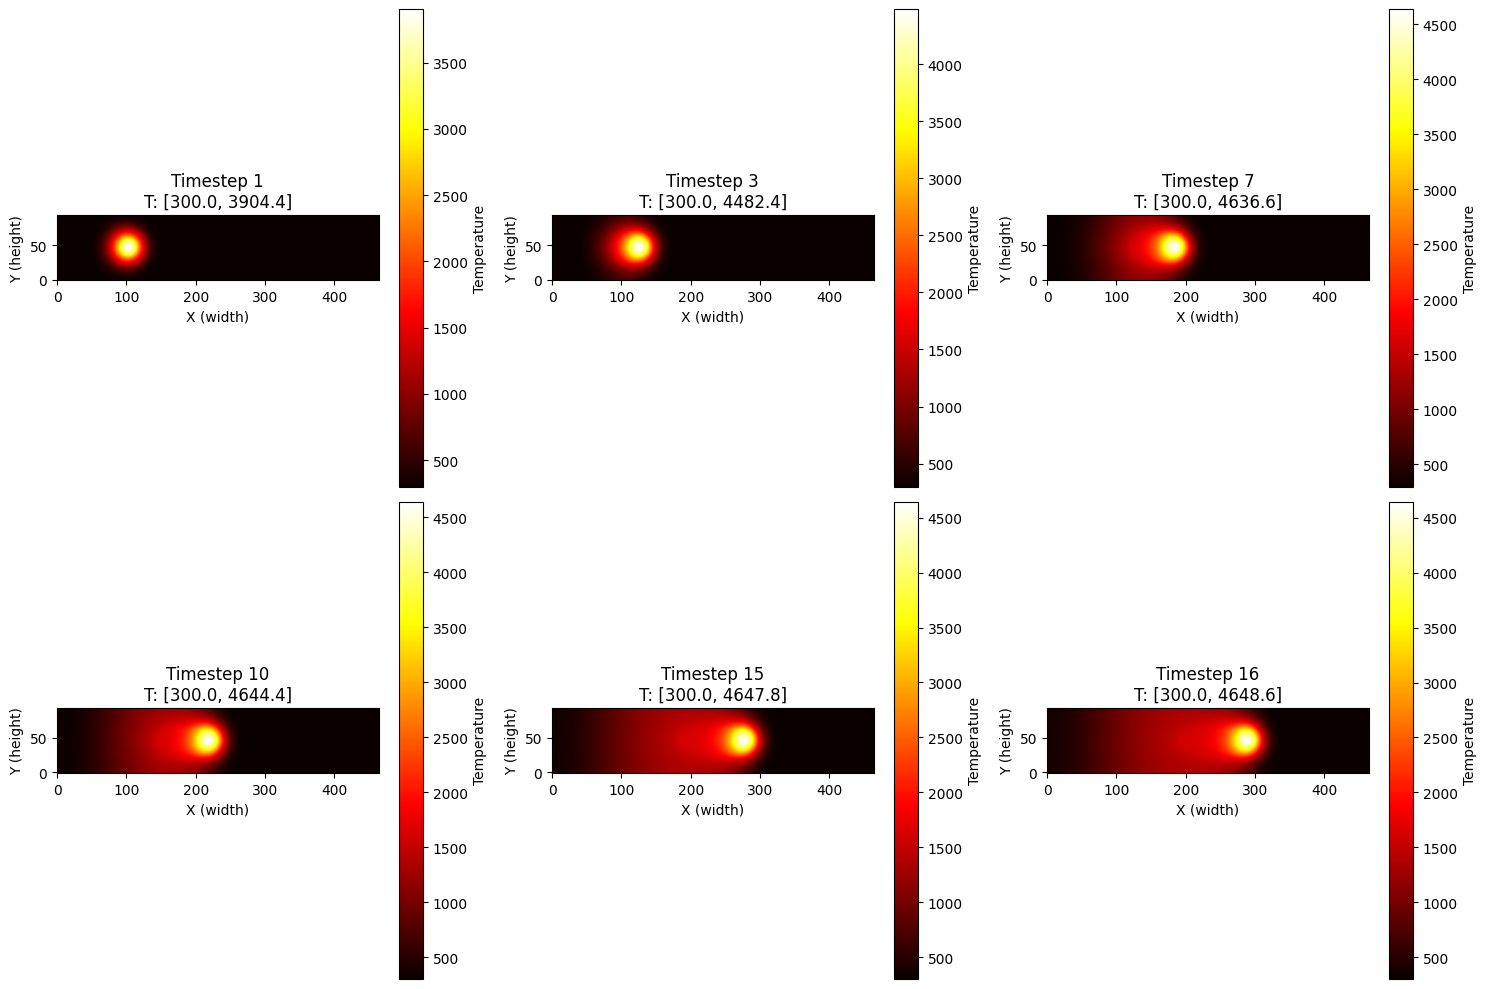


Dataset info:
  Total timesteps available: 17
  Timestep indices in this split: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Load multiple timesteps to find one with interesting temperature data
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, timestep_idx in enumerate([1, 3, 7, 10, 15, 16]):
    if timestep_idx >= len(dataset):
        timestep_idx = len(dataset) - 1
    
    sample = dataset[timestep_idx]
    temp_data = sample['data'][0].numpy()  # First (and only) channel
    temp_mask = sample['mask'].numpy()
    
    # Apply mask and get valid data
    temp_data_masked = np.ma.masked_where(~temp_mask, temp_data)
    
    # Get statistics of valid data
    valid_data = temp_data[temp_mask]
    
    ax = axes[i]
    if valid_data.size > 0:
        # Plot with proper color range
        im = ax.imshow(temp_data_masked, cmap='hot', origin='lower', 
                      vmin=valid_data.min(), vmax=valid_data.max())
        plt.colorbar(im, ax=ax, label='Temperature')
        ax.set_title(f'Timestep {sample["timestep"]}\nT: [{valid_data.min():.1f}, {valid_data.max():.1f}]')
    else:
        ax.imshow(temp_mask, cmap='gray', origin='lower')
        ax.set_title(f'Timestep {sample["timestep"]}\n(No valid data)')
    
    ax.set_xlabel('X (width)')
    ax.set_ylabel('Y (height)')

plt.tight_layout()
plt.show()

print("\nDataset info:")
print(f"  Total timesteps available: {len(dataset)}")
print(f"  Timestep indices in this split: {dataset.timesteps}")

### Sliding Window DataLoader

In [ ]:
from lasernet.utils.plot import plot_sliding_window

dataset = TemperatureSequenceDataset(
        split="train",
        sequence_length=3,
        target_offset=1,
        plane_index=-1,
    )

frame = dataset[2]

print("Sample sequence structure:")
print(f"  context shape: {frame['context'].shape}")
print(f"  target shape: {frame['target'].shape}")
print(f"  timestep: {frame['timestep']}")

loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

print(f"DataLoader created with batch_size=2")
print(f"Total batches: {len(loader)}")


Sample structure:
  context shape: torch.Size([3, 1, 94, 465])
  target shape: torch.Size([1, 94, 465])
  timestep: 2
DataLoader created with batch_size=2
Total batches: 14



Using device: cpu
  data shape: torch.Size([1, 3, 1, 94, 465])
  target shape: torch.Size([1, 1, 94, 465])
  timesteps: [[0, 1, 2]]
  target timestep: [3]


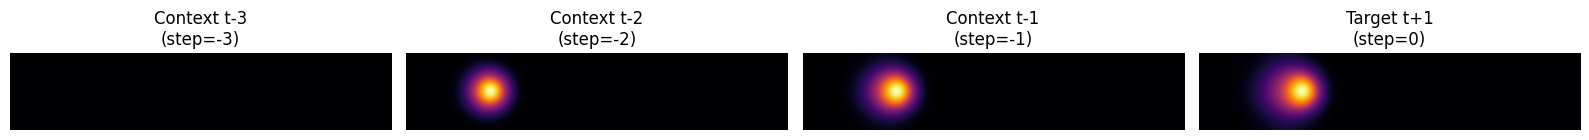

  data shape: torch.Size([1, 3, 1, 94, 465])
  target shape: torch.Size([1, 1, 94, 465])
  timesteps: [[1, 2, 3]]
  target timestep: [4]


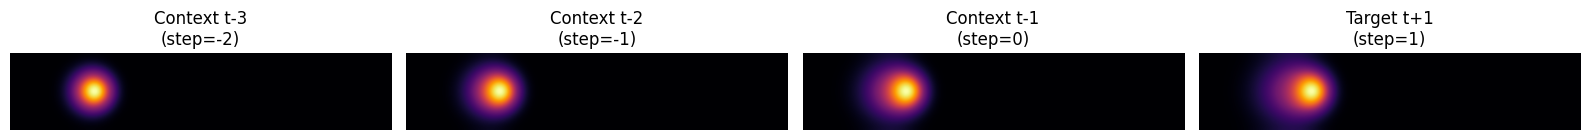

  data shape: torch.Size([1, 3, 1, 94, 465])
  target shape: torch.Size([1, 1, 94, 465])
  timesteps: [[2, 3, 4]]
  target timestep: [5]


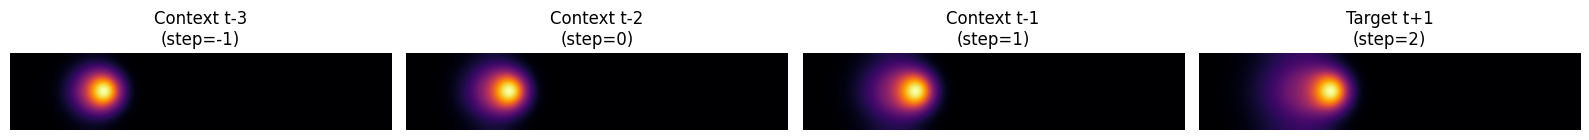

  data shape: torch.Size([1, 3, 1, 94, 465])
  target shape: torch.Size([1, 1, 94, 465])
  timesteps: [[3, 4, 5]]
  target timestep: [6]


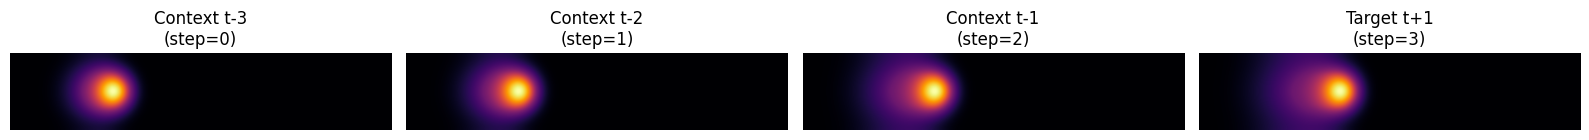

  data shape: torch.Size([1, 3, 1, 94, 465])
  target shape: torch.Size([1, 1, 94, 465])
  timesteps: [[4, 5, 6]]
  target timestep: [7]


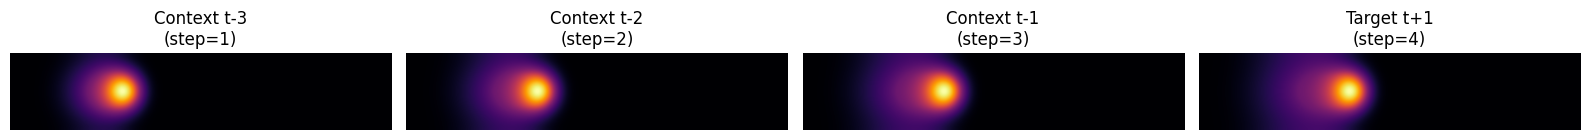

  data shape: torch.Size([1, 3, 1, 94, 465])
  target shape: torch.Size([1, 1, 94, 465])
  timesteps: [[5, 6, 7]]
  target timestep: [8]


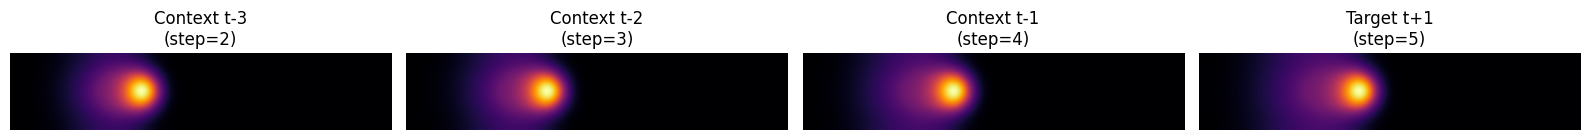

In [10]:
# Get first batch
"""
batch = next(iter(loader))
print(f"\nFirst batch:")
print(f"  data shape: {batch['context'].shape}")  # [4, 1, H, W]
print(f"  target shape: {batch['target'].shape}")  # [4, H, W]
print(f"  timesteps: {batch['timestep'].tolist()}")
"""
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device: {device}")

# Training loop
for batch in loader:
    context = batch["context"].float().to(device)  # [B, seq_len, 1, H, W]
    target = batch["target"].float().to(device)    # [B, 1, H, W]
    context_timestep = batch['context_timesteps'].to(device)
    target_timestep = batch['target_timestep'].to(device)

    print(f"  data shape: {context.shape}")  # [4, 1, H, W]
    print(f"  target shape: {target.shape}")  # [4, H, W]
    print(f"  timesteps: {context_timestep.tolist()}")
    print(f"  target timestep: {target_timestep.tolist()}")

    plot_sliding_window(batch, window_index=0)

    if context_timestep[0][0] >= 5:
        break

## Load Different Field Types

Temperature has 1 channel, microstructure has 10 channels (9 IPF components + origin index).

In [11]:
# Temperature data (1 channel)
temp_dataset = PointCloudDataset(
    field="temperature",
    plane="xy",
    split="train",
    plane_index=-1, # top (highest z coordinate)
)
temp_sample = temp_dataset[0]
print(f"Temperature data shape: {temp_sample['data'].shape}")
print(f"  Channels: {temp_sample['data'].shape[0]}")

# Microstructure data (10 channels)
micro_dataset = PointCloudDataset(
    field="microstructure",
    plane="xy",
    split="train",
    plane_index=-1, # top (highest z coordinate)
)
micro_sample = micro_dataset[0]
print(f"\nMicrostructure data shape: {micro_sample['data'].shape}")
print(f"  Channels: {micro_sample['data'].shape[0]}")
print(f"  (9 IPF components + 1 origin index)")

Temperature data shape: torch.Size([1, 94, 465])
  Channels: 1

Microstructure data shape: torch.Size([10, 94, 465])
  Channels: 10
  (9 IPF components + 1 origin index)


## Load Different Planes (XY, YZ, XZ)

In [12]:
# Load different plane orientations
for plane in ["xy", "yz", "xz"]:
    ds = PointCloudDataset(
        field="temperature",
        plane=plane,
        split="train",
    )
    frame = ds[0]
    print(f"{plane.upper()} plane:")
    print(f"  Shape: {frame['data'].shape}")
    print(f"  Width axis: {ds.width_axis}")
    print(f"  Height axis: {ds.height_axis}")
    print(f"  Fixed axis: {ds.fixed_axis} (value: {ds.plane_coord:.6f})")
    print()

XY plane:
  Shape: torch.Size([1, 94, 465])
  Width axis: x
  Height axis: y
  Fixed axis: z (value: 0.000050)

YZ plane:
  Shape: torch.Size([1, 94, 47])
  Width axis: z
  Height axis: y
  Fixed axis: x (value: 0.000500)

XZ plane:
  Shape: torch.Size([1, 47, 465])
  Width axis: x
  Height axis: z
  Fixed axis: y (value: 0.000101)



## Custom Plane Index

You can select a specific plane slice by index (0=first, -1=last, None=middle).

In [13]:
# First slice
dataset_first = PointCloudDataset(
    field="temperature",
    plane="xy",
    split="train",
    plane_index=0,  # First slice
)
print(f"First XY slice (index=0): z={dataset_first.plane_coord:.6f}")

# Last slice
dataset_last = PointCloudDataset(
    field="temperature",
    plane="xy",
    split="train",
    plane_index=-1,  # Last slice
)
print(f"Last XY slice (index=-1): z={dataset_last.plane_coord:.6f}")

# Middle slice (default)
dataset_middle = PointCloudDataset(
    field="temperature",
    plane="xy",
    split="train",
    plane_index=None,  # Middle slice (default)
)
print(f"Middle XY slice (index=None): z={dataset_middle.plane_coord:.6f}")

First XY slice (index=0): z=0.000000
Last XY slice (index=-1): z=0.000100
Middle XY slice (index=None): z=0.000050


# Multi-Slice Sequence Dataset

The `SliceSequenceDataset` provides **spatial diversity** while maintaining **temporal consistency**. Each sample is a temporal sequence for one spatial slice, allowing the model to learn from many different melt pool positions.

In [23]:
# Create SliceSequenceDataset with all Z-slices
slice_dataset = SliceSequenceDataset(
    field="temperature",
    plane="xz",
    split="train",
    sequence_length=3,
    target_offset=1,
)

print(f"SliceSequenceDataset:")
print(f"  Total samples: {len(slice_dataset)}")
print(f"  Valid sequences: {slice_dataset.num_valid_sequences}")
print(f"  Number of Y-slices: {len(slice_dataset.slice_coords)}")
print(f"  Samples per timestep: {len(slice_dataset.slice_coords)}")
print(f"  Formula: {slice_dataset.num_valid_sequences} sequences × {len(slice_dataset.slice_coords)} slices = {len(slice_dataset)} samples")
print(f"\nY-coordinate range:")
print(f"  Min: {slice_dataset.slice_coords[0]:.8f}")
print(f"  Max: {slice_dataset.slice_coords[-1]:.8f}")
print(f"  Step: ~{(slice_dataset.slice_coords[1] - slice_dataset.slice_coords[0]):.8f}")

# Get a sample
sample = slice_dataset[0]
print(f"\nSample slice structure:")
print(f"  context shape: {sample['context'].shape}  # [seq_len, channels, height, width]")
print(f"  target shape: {sample['target'].shape}  # [channels, height, width]")
print(f"  slice_coord: {sample['slice_coord']:.8f}")
print(f"  timestep_start: {sample['timestep_start']}")
print(f"  context_timesteps: {sample['context_timesteps'].tolist()}")
print(f"  target_timestep: {sample['target_timestep']}")

SliceSequenceDataset:
  Total samples: 1316
  Valid sequences: 14
  Number of Y-slices: 94
  Samples per timestep: 94
  Formula: 14 sequences × 94 slices = 1316 samples

Y-coordinate range:
  Min: 0.00000000
  Max: 0.00020000
  Step: ~0.00000215

Sample slice structure:
  context shape: torch.Size([3, 1, 47, 465])  # [seq_len, channels, height, width]
  target shape: torch.Size([1, 47, 465])  # [channels, height, width]
  slice_coord: 0.00000000
  timestep_start: 0
  context_timesteps: [0, 1, 2]
  target_timestep: 3


## Visualize Spatial Diversity: Different Z-Slices

Show how temperature varies at different Z-heights (depths) in the melt pool.

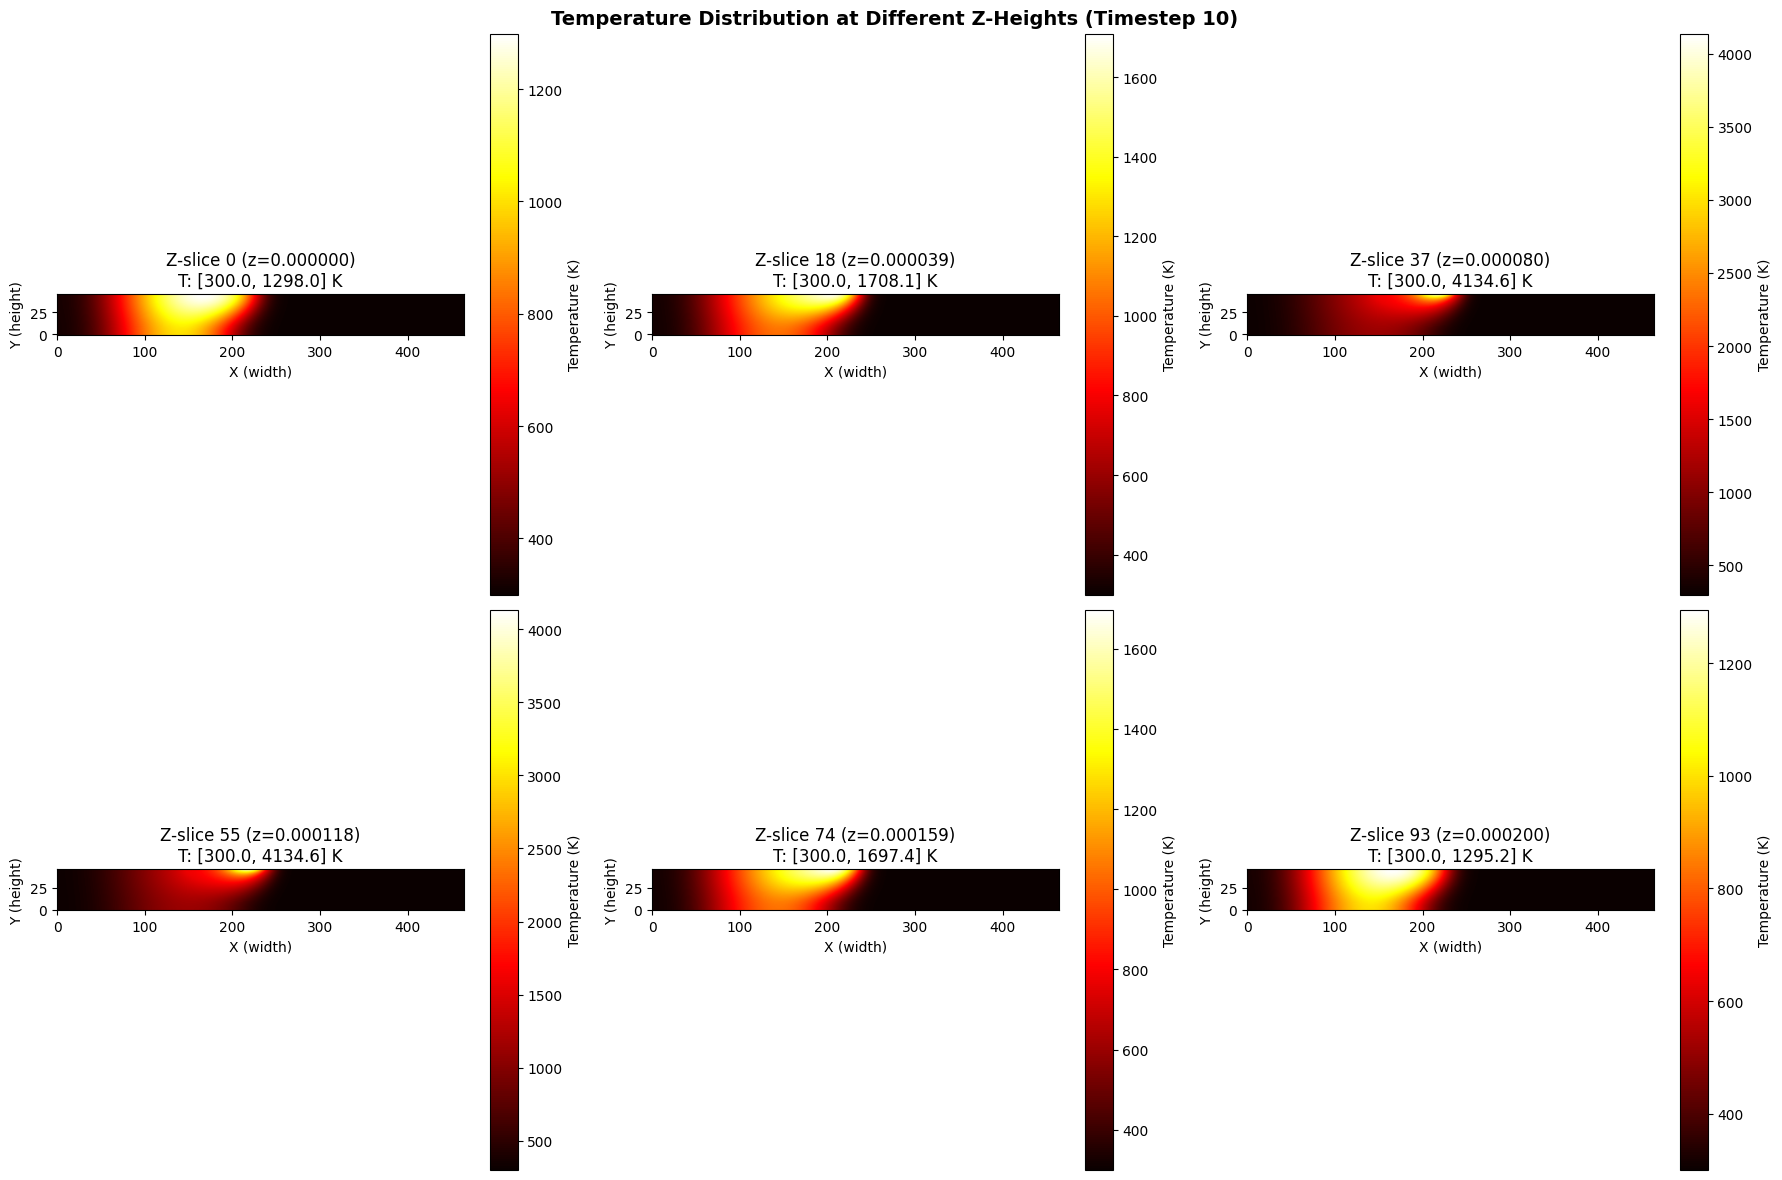


Showing 6 different Z-slices from timestep 10


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a timestep and show temperature at different Z-slices
timestep = 10
num_slices_to_show = 6

# Select slice indices evenly spaced through depth
slice_indices = np.linspace(0, len(slice_dataset.slice_coords)-1, num_slices_to_show, dtype=int)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

base_dataset = slice_dataset.base_dataset

for idx, slice_idx in enumerate(slice_indices):
    z_coord = slice_dataset.slice_coords[slice_idx]
    
    # Get temperature data at this Z-slice
    sample = base_dataset.get_slice(timestep, z_coord)
    temp_data = sample['data'][0].numpy()
    temp_mask = sample['mask'].numpy()
    
    # Apply mask
    temp_data_masked = np.ma.masked_where(~temp_mask, temp_data)
    valid_data = temp_data[temp_mask]
    
    ax = axes[idx]
    if valid_data.size > 0 and valid_data.std() > 0.1:
        # Plot with temperature colormap
        im = ax.imshow(temp_data_masked, cmap='hot', origin='lower',
                      vmin=valid_data.min(), vmax=valid_data.max())
        plt.colorbar(im, ax=ax, label='Temperature (K)')
        ax.set_title(f'Z-slice {slice_idx} (z={z_coord:.6f})\nT: [{valid_data.min():.1f}, {valid_data.max():.1f}] K')
    else:
        # Uniform temperature - show with gray colormap
        im = ax.imshow(temp_data_masked, cmap='gray', origin='lower')
        plt.colorbar(im, ax=ax, label='Temperature (K)')
        ax.set_title(f'Z-slice {slice_idx} (z={z_coord:.6f})\nUniform: {valid_data.mean():.1f} K')
    
    ax.set_xlabel('X (width)')
    ax.set_ylabel('Y (height)')

plt.suptitle(f'Temperature Distribution at Different Z-Heights (Timestep {timestep})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nShowing {num_slices_to_show} different Z-slices from timestep {timestep}")

## Visualize Temporal Evolution for One Slice

Show how ONE spatial slice evolves through time (maintaining temporal consistency).

Sample 100 details:
  Y-coordinate: 0.00001290
  Timestep range: [1, 2, 3] → 4


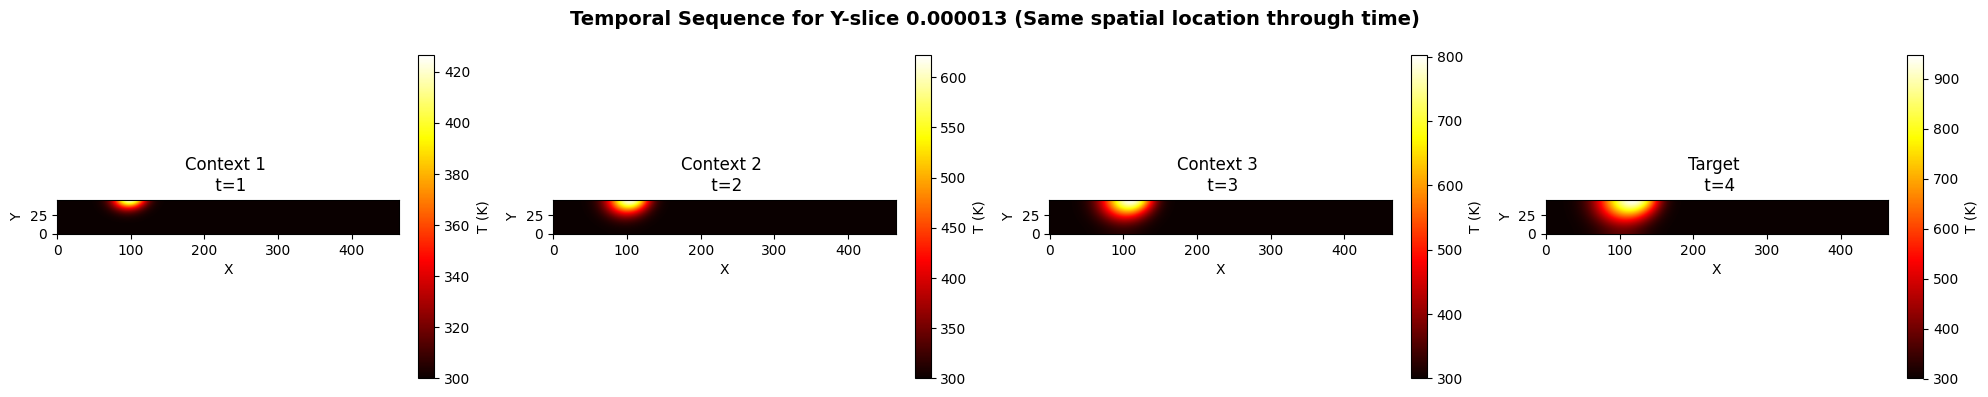


This sequence shows temporal consistency:
  ✓ Same Z-coordinate throughout: 0.00001290
  ✓ Consecutive timesteps: [1, 2, 3] → 4
  ✓ Model learns physics-based evolution at this spatial location


In [ ]:
# Get a sequence sample (context + target for ONE Y-slice)
sample_idx = 100  # Pick a sample
sample = slice_dataset[sample_idx]

print(f"Sample {sample_idx} details:")
print(f"  Y-coordinate: {sample['slice_coord']:.8f}")
print(f"  Timestep range: {sample['context_timesteps'].tolist()} → {sample['target_timestep']}")

# Visualize the sequence: context frames + target
num_context = sample['context'].shape[0]
fig, axes = plt.subplots(1, num_context + 1, figsize=(20, 4))

# Plot context frames
for i in range(num_context):
    temp_data = sample['context'][i, 0].numpy()  # [H, W]
    temp_mask = sample['context_mask'][i].numpy()
    temp_data_masked = np.ma.masked_where(~temp_mask, temp_data)
    valid_data = temp_data[temp_mask]
    
    ax = axes[i]
    if valid_data.size > 0:
        im = ax.imshow(temp_data_masked, cmap='hot', origin='lower',
                      vmin=300, vmax=valid_data.max())
        plt.colorbar(im, ax=ax, label='T (K)', fraction=0.046)
        ax.set_title(f'Context {i+1} \n t={sample["context_timesteps"][i]}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

# Plot target frame
temp_data = sample['target'][0].numpy()
temp_mask = sample['target_mask'].numpy()
temp_data_masked = np.ma.masked_where(~temp_mask, temp_data)
valid_data = temp_data[temp_mask]

ax = axes[num_context]
if valid_data.size > 0:
    im = ax.imshow(temp_data_masked, cmap='hot', origin='lower',
                  vmin=300, vmax=valid_data.max())
    plt.colorbar(im, ax=ax, label='T (K)', fraction=0.046)
    ax.set_title(f'Target \n t={sample["target_timestep"]}')
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.suptitle(f'Temporal Sequence for Y-slice {sample["slice_coord"]:.6f} (Same spatial location through time)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Same Y-coordinate throughout: {sample['slice_coord']:.8f}")
print(f"Consecutive timesteps: {sample['context_timesteps'].tolist()} → {sample['target_timestep']}")


## Use SliceSequenceDataset with DataLoader

In [28]:
# Create DataLoader for training
batch_size = 1
train_loader = DataLoader(
    slice_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)

print(f"DataLoader created:")
print(f"  Batch size: {batch_size}")
print(f"  Total batches: {len(train_loader)}")
print(f"  Total samples: {len(slice_dataset)}")

# Get a batch
batch = next(iter(train_loader))
print(f"\nBatch structure:")
print(f"  context: {batch['context'].shape}  # [B, seq_len, C, H, W]")
print(f"  target: {batch['target'].shape}  # [B, C, H, W]")
print(f"  context_mask: {batch['context_mask'].shape}  # [B, seq_len, H, W]")
print(f"  target_mask: {batch['target_mask'].shape}  # [B, H, W]")
print(f"\nSlice coordinates in this batch:")
for i in range(min(4, len(batch['slice_coord']))):
    print(f"  Sample {i}: y={batch['slice_coord'][i]:.8f}, timestep_start={batch['timestep_start'][i]}")

DataLoader created:
  Batch size: 1
  Total batches: 1316
  Total samples: 1316

Batch structure:
  context: torch.Size([1, 3, 1, 47, 465])  # [B, seq_len, C, H, W]
  target: torch.Size([1, 1, 47, 465])  # [B, C, H, W]
  context_mask: torch.Size([1, 3, 47, 465])  # [B, seq_len, H, W]
  target_mask: torch.Size([1, 47, 465])  # [B, H, W]

Slice coordinates in this batch:
  Sample 0: y=0.00000000, timestep_start=0
